In [3]:
import cv2
import json
import matplotlib.pyplot as plt
%matplotlib inline


def load_image(image_path):
    """
    加载图片函数
    :param image_path: 图片的路径
    :return: 加载成功返回图片对象，失败返回None
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"无法加载图片: {image_path}")
        return None
    return image


def load_json(json_path):
    """
    加载JSON文件函数
    :param json_path: JSON文件的路径
    :return: 解析后的JSON数据（字典形式），若加载失败返回None
    """
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        return data
    except FileNotFoundError:
        print(f"找不到JSON文件: {json_path}")
        return None
    except json.JSONDecodeError:
        print(f"JSON文件解析错误: {json_path}")
        return None


def draw_bboxes(image, bboxes):
    """
    在图片上绘制边界框的函数
    :param image: 图片对象
    :param bboxes: 边界框坐标信息列表，格式为[[x1, y1, x2, y2],...]
    :return: 绘制好边界框的图片对象
    """
    for box in bboxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # 用绿色框，线宽为2绘制矩形框
    return image




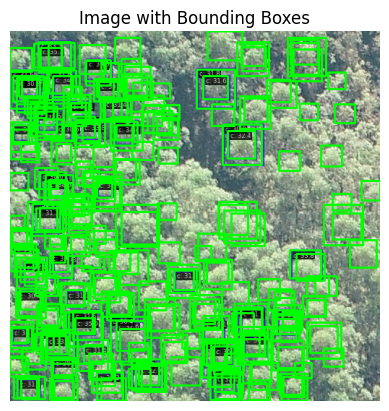

In [4]:

image_path = "outputs\\20241125_021823\\visualize\\100_0001_0001_Cropped_13_vis.jpg"  # 替换为你的实际图片路径
json_path = "outputs\\20241125_021823\\results\\100_0001_0001_Cropped_13_result.json"  # 替换为你的实际JSON文件路径

image = load_image(image_path)
if image is None:
    exit(1)

json_data = load_json(json_path)
if json_data is None:
    exit(1)

bboxes = json_data.get("bboxes", [])
result_image = draw_bboxes(image, bboxes)

# 将BGR格式的图像转换为RGB格式（因为matplotlib默认显示RGB图像）
result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
plt.imshow(result_image_rgb)
plt.title("Image with Bounding Boxes")
plt.axis('off')  # 关闭坐标轴显示
plt.show()

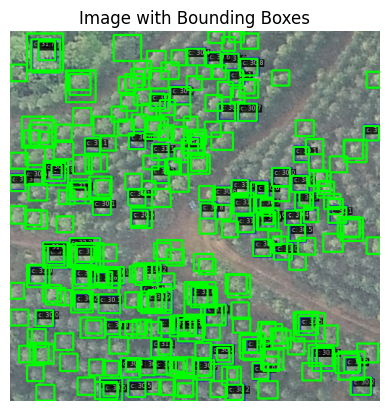

In [5]:

image_path = "outputs\\20241125_021823\\visualize\DJI_0042_Cropped_24_vis.jpg"  # 替换为你的实际图片路径
json_path = "outputs\\20241125_021823\\results\DJI_0042_Cropped_24_result.json"  # 替换为你的实际JSON文件路径

image = load_image(image_path)
if image is None:
    exit(1)

json_data = load_json(json_path)
if json_data is None:
    exit(1)

bboxes = json_data.get("bboxes", [])
result_image = draw_bboxes(image, bboxes)

# 将BGR格式的图像转换为RGB格式（因为matplotlib默认显示RGB图像）
result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
plt.imshow(result_image_rgb)
plt.title("Image with Bounding Boxes")
plt.axis('off')  # 关闭坐标轴显示
plt.show()

合并后的JSON文件已保存至: data/Eucalyptus_canopy/annotations/instances_merged.json
   Metric  Min    Max         Mean      Std Dev
0   Width    0    192    29.797403    16.024435
1  Height    0    180    28.478832    15.235054
2    Area    0  28175  1057.965936  1391.356778
统计表格已保存至 work_dir/bboxes\bbox_statistics.csv


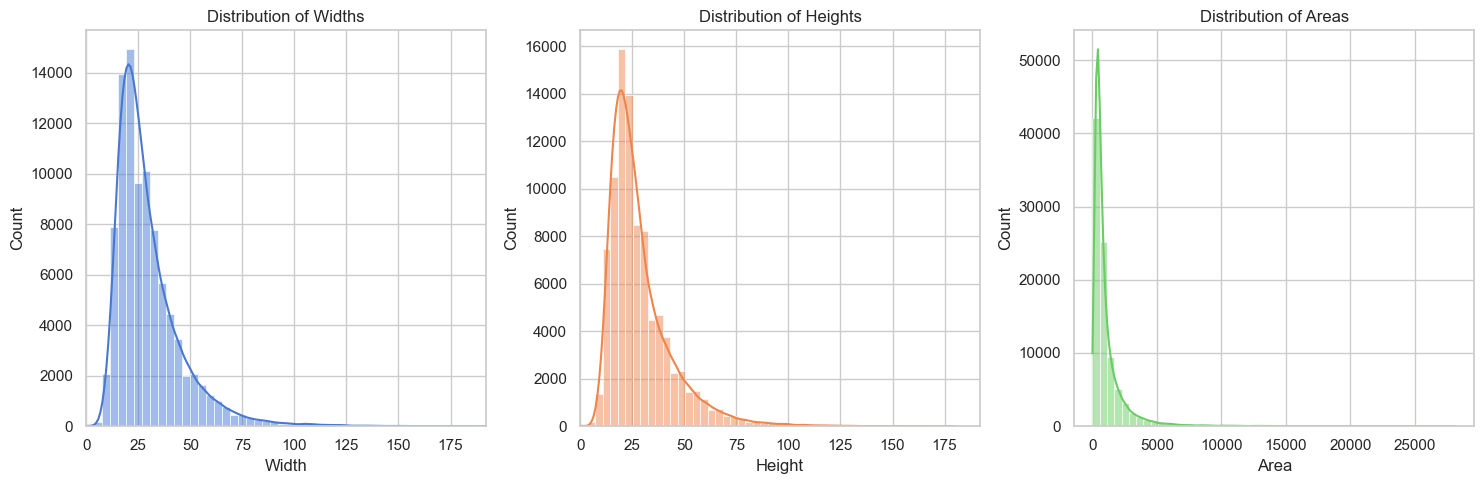

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def load_json(json_path):
    """
    加载JSON文件
    :param json_path: JSON文件路径
    :return: 解析后的JSON数据（字典形式），若加载失败返回None
    """
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        return data
    except FileNotFoundError:
        print(f"找不到JSON文件: {json_path}")
        return None
    except json.JSONDecodeError:
        print(f"JSON文件解析错误: {json_path}")
        return None


def merge_json_files(json_files, output_path):
    """
    合并多个COCO格式的JSON文件
    :param json_files: JSON文件路径列表
    :param output_path: 合并后的JSON文件保存路径
    """
    merged_data = {"images": [], "annotations": [], "categories": []}
    image_id_offset = 0
    annotation_id_offset = 0

    for json_file in json_files:
        data = load_json(json_file)
        if data is None:
            continue

        # 合并categories（假设类别一致）
        if not merged_data["categories"]:
            merged_data["categories"] = data["categories"]

        # 合并images和annotations
        for image in data["images"]:
            image["id"] += image_id_offset
            merged_data["images"].append(image)

        for annotation in data["annotations"]:
            annotation["id"] += annotation_id_offset
            annotation["image_id"] += image_id_offset
            merged_data["annotations"].append(annotation)

        # 更新偏移量
        image_id_offset += len(data["images"])
        annotation_id_offset += len(data["annotations"])

    # 保存合并后的JSON文件
    with open(output_path, "w") as f:
        json.dump(merged_data, f)
    print(f"合并后的JSON文件已保存至: {output_path}")


def generate_summary_table(json_path, save_dir=None):
    """
    生成宽度、高度和面积的统计表格
    :param json_path: 合并后的JSON文件路径
    :param save_dir: 保存表格的目录（可选）
    """
    data = load_json(json_path)
    if data is None:
        return

    annotations = data['annotations']

    # 获取宽度、高度、面积
    widths = []
    heights = []
    areas = []

    for ann in annotations:
        x, y, w, h = ann['bbox']
        widths.append(w)
        heights.append(h)
        areas.append(w * h)

    # 生成统计表格
    summary = {
        "Metric": ["Width", "Height", "Area"],
        "Min": [min(widths), min(heights), min(areas)],
        "Max": [max(widths), max(heights), max(areas)],
        "Mean": [sum(widths) / len(widths), sum(heights) / len(heights), sum(areas) / len(areas)],
        "Std Dev": [pd.Series(widths).std(), pd.Series(heights).std(), pd.Series(areas).std()],
    }

    summary_df = pd.DataFrame(summary)
    print(summary_df)

    # 保存为 CSV 文件
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        csv_path = os.path.join(save_dir, 'bbox_statistics.csv')
        summary_df.to_csv(csv_path, index=False)
        print(f"统计表格已保存至 {csv_path}")


def plot_bbox_histograms_with_normalized_axes(json_path, save_dir=None):
    """
    绘制直方图并标准化宽度和高度的坐标轴
    :param json_path: 合并后的JSON文件路径
    :param save_dir: 保存图片的目录（可选）
    """
    data = load_json(json_path)
    if data is None:
        return

    annotations = data['annotations']

    # 获取宽度、高度、面积
    widths = []
    heights = []
    areas = []

    for ann in annotations:
        x, y, w, h = ann['bbox']
        widths.append(w)
        heights.append(h)
        areas.append(w * h)

    # 设置配色
    sns.set_theme(style="whitegrid")
    palette = sns.color_palette("muted", n_colors=3)

    # 确定标准化的坐标轴范围
    max_x = max(max(widths), max(heights))

    # 绘制直方图
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sns.histplot(widths, bins=50, color=palette[0], kde=True)
    plt.xlabel('Width')
    plt.ylabel('Count')
    plt.title('Distribution of Widths')
    plt.xlim(0, max_x)

    plt.subplot(1, 3, 2)
    sns.histplot(heights, bins=50, color=palette[1], kde=True)
    plt.xlabel('Height')
    plt.ylabel('Count')
    plt.title('Distribution of Heights')
    plt.xlim(0, max_x)

    plt.subplot(1, 3, 3)
    sns.histplot(areas, bins=50, color=palette[2], kde=True)
    plt.xlabel('Area')
    plt.ylabel('Count')
    plt.title('Distribution of Areas')

    plt.tight_layout()
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, 'bbox_distribution_normalized.png'))
    plt.show()


# 调用脚本
annotation_files = [
    "data/Eucalyptus_canopy/annotations/instances_train2017.json",
    "data/Eucalyptus_canopy/annotations/instances_val2017.json"
]
merged_json_path = "data/Eucalyptus_canopy/annotations/instances_merged.json"
output_directory = "work_dir/bboxes"

os.makedirs(output_directory, exist_ok=True)

# 合并 JSON 文件
merge_json_files(annotation_files, merged_json_path)

# 生成统计表格
generate_summary_table(merged_json_path, save_dir=output_directory)

# 绘制直方图（标准化坐标轴）
plot_bbox_histograms_with_normalized_axes(merged_json_path, save_dir=output_directory)



In [7]:
import os
import json
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

# 加载 JSON 文件
def load_json(json_path):
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        return data
    except FileNotFoundError:
        print(f"找不到JSON文件: {json_path}")
        return None
    except json.JSONDecodeError:
        print(f"JSON文件解析错误: {json_path}")
        return None

# 计算平均框尺寸以及小框和大框的尺寸
def calculate_bbox_statistics(annotations):
    widths = []
    heights = []
    areas = []

    for ann in annotations:
        w, h = ann["bbox"][2], ann["bbox"][3]
        widths.append(w)
        heights.append(h)
        areas.append(w * h)

    avg_width = np.mean(widths)
    avg_height = np.mean(heights)
    avg_area = np.mean(areas)
    std_area = np.std(areas)

    # 大框和小框的定义，面积大于和小于平均面积的框
    big_bboxes = [ann for ann in annotations if ann["bbox"][2] * ann["bbox"][3] > avg_area+std_area+100]
    small_bboxes = [ann for ann in annotations if ann["bbox"][2] * ann["bbox"][3] < avg_area-std_area-50]

    return avg_width, avg_height, big_bboxes, small_bboxes

# 抽样并绘制带框的图像
def sample_and_visualize(json_path, image_dir, output_dir, sample_fraction=0.1):
    data = load_json(json_path)
    if data is None:
        return

    annotations = data["annotations"]
    images = {img["id"]: img for img in data["images"]}

    # 计算框尺寸统计
    avg_width, avg_height, big_bboxes, small_bboxes = calculate_bbox_statistics(annotations)

    # 创建文件夹用于保存
    sampled_images_dir = os.path.join(output_dir, "sampled_images_std+100-60")
    os.makedirs(sampled_images_dir, exist_ok=True)

    # 抽样图片
    sampled_image_ids = random.sample(list(images.keys()), int(sample_fraction * len(images)))

    for image_id in sampled_image_ids:
        img_meta = images[image_id]
        img_path = os.path.join(image_dir, img_meta["file_name"])
        img_annotations = [ann for ann in annotations if ann["image_id"] == image_id]

        # 绘制图片及标注
        if os.path.exists(img_path):
            img = plt.imread(img_path)
            plt.figure(figsize=(10, 10))
            plt.imshow(img)
            ax = plt.gca()

            # 绘制大框和小框
            for ann in img_annotations:
                x, y, w, h = ann["bbox"]
                color = "red" if ann in big_bboxes else "blue"  # 大框红色，小框蓝色
                rect = Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor="none")
                ax.add_patch(rect)

            # 关闭坐标轴显示
            plt.axis("off")
            plt.title(f"Image: {img_meta['file_name']}, Avg Width: {avg_width:.2f}, Avg Height: {avg_height:.2f}")
            plt.savefig(os.path.join(sampled_images_dir, img_meta["file_name"]))
            plt.close()

# 调用脚本
annotation_file = "data/Eucalyptus_canopy/annotations/instances_merged.json"
image_directory = "data/Eucalyptus_canopy/merged_images"
output_directory = "work_dir/bboxes"

# 抽样并可视化
sample_and_visualize(annotation_file, image_directory, output_directory)


### 离群度锚框分析


In [3]:
!python tools/analyze_wiseiou.py --dataset_path data/Eucalyptus_canopy --output_dir output


^C


In [6]:
import os
import shutil

def delete_folder(folder_path):
    """
    删除指定的文件夹，并解除所有可能的文件占用问题。
    :param folder_path: 要删除的文件夹路径
    """
    try:
        # 检查文件夹是否存在
        if os.path.exists(folder_path):
            # 删除文件夹及其内容
            shutil.rmtree(folder_path, ignore_errors=True)
            # 确认删除后再次检查
            if os.path.exists(folder_path):
                print(f"文件夹 {folder_path} 存在占用，尝试逐个文件删除...")
                for root, dirs, files in os.walk(folder_path, topdown=False):
                    for file in files:
                        file_path = os.path.join(root, file)
                        try:
                            os.remove(file_path)
                        except Exception as e:
                            print(f"无法删除文件 {file_path}: {e}")
                    for dir in dirs:
                        dir_path = os.path.join(root, dir)
                        try:
                            os.rmdir(dir_path)
                        except Exception as e:
                            print(f"无法删除文件夹 {dir_path}: {e}")
                # 尝试再次删除文件夹
                os.rmdir(folder_path)
            if not os.path.exists(folder_path):
                print(f"文件夹 {folder_path} 已成功删除！")
            else:
                print(f"文件夹 {folder_path} 删除失败，请检查文件占用情况！")
        else:
            print(f"文件夹 {folder_path} 不存在，无需删除。")
    except Exception as e:
        print(f"删除文件夹 {folder_path} 时发生错误: {e}")



In [13]:
# 示例调用
output_folder = "data\Eucalyptus_canopy_5%"
delete_folder(output_folder)

文件夹 data\Eucalyptus_canopy_5% 已成功删除！
